## Loan Prediction - Stage 1
DO NOT EDIT DIRECTLY, DOWNLOAD AND EDIT THE DOWNLOADED FILE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**LOAN PREDICTION**<br>
* Memprediksi kelayakan customer yang layak diberikan pinjaman. <br>


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.19.5
pandas version :  1.1.5
seaborn version :  0.11.2


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

# Data Pre-processing

## Data Exploration (Load and Describe Data )

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Collab_Notebooks/Training Data.csv')

In [ ]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


Kita dapat melihat bahwa:
* Dataframe memiliki total 252000 baris dan 13 kolom
* Dataframe tidak memiliki data yang null 
* Target klasifikasi sepertinya adalah kolom `Risk_Flag` dengan tipe data `int64` namun isinya adalah boolean 0 dan 1
* Berarti sisanya adalah *feature*
* Id sepertinya merupakan unique id sehingga bisa di drop di awal karena tidak memilki insight apapun

Dari informasi di atas, kita bisa pisahkan kolom kategorical dan numerical sebagai berikut:

In [ ]:
cats = df.select_dtypes(include='object').columns
nums = df.select_dtypes(exclude='object').columns[1:]
print('Kolom kategory : ', cats)
print('Kolom Number : ', nums)

Kolom kategory :  Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE'],
      dtype='object')
Kolom Number :  Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag'],
      dtype='object')


### Statistical summary dengan `df.describe()`
Selanjutnya kita munculkan ringkasan statistik dataframe, baik untuk numerical dan categorical. Hal ini dilakukan untuk mengecek secara singkat akan keberadaan outlier dan karakteristik distribusi untuk `feature` numeric.

In [ ]:
round(df[nums].describe(),2)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.00,252000.00,252000.00,252000.00,252000.0,252000.00
mean,4997116.67,49.95,10.08,6.33,12.0,0.12
std,2878311.01,17.06,6.00,3.65,1.4,0.33
min,10310.00,21.00,0.00,0.00,10.0,0.00
25%,2503015.00,35.00,5.00,3.00,11.0,0.00
50%,5000694.50,50.00,10.00,6.00,12.0,0.00
75%,7477502.00,65.00,15.00,9.00,13.0,0.00
max,9999938.00,79.00,20.00,14.00,14.0,1.00


Beberapa pengamatan dari *statistical summary* kolom numerik di atas:
* Distribusi nilai di kolom `Income`, `Age`, `Experience`, `CURRENT_JOB_YRS`, dan `CURRENT_HOUSE_YRS` terlihat normal (*mean* dan *median* cukup dekat, dan nilai Q2 kira2 tepat di tengah2 Q1 - Q3)
* Kolom `Risk_Flag` merupakan kolom target 

In [ ]:
df[cats].describe()

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE
count,252000,252000,252000,252000,252000,252000
unique,2,3,2,51,317,29
top,single,rented,no,Physician,Vijayanagaram,Uttar_Pradesh
freq,226272,231898,176000,5957,1259,28400


Beberapa pengamatan dari *statistical summary* kolom kategorikal di atas:
* Mayoritas data adalah single (Top kolom `Married/Single` adalah `single` dengan frekuensi 226272)
* Mayoritas data adalah rented (Top kolom `House_Ownership` adalah `single` dengan frekuensi 231898)
* Mayoritas data adalah no (Top kolom `Car_Ownership` adalah `single` dengan frekuensi 176000)
* Kolom `Profession`, `CITY`, dan `STATE` memiliki jumlah nilai unik yang banyak; ada kemungkinan tidak terlalu berguna untuk klasifikasi
* Sebaran nilai di kolom , `Profession`, `CITY`, dan `STATE` terlihat cukup merata, sedangkan `Married/Single` , `Car_Ownership` dan `House_Ownership` terlihat didominasi nilai tertentu

### Value Counting
Kita dapat memastikan pengamatan mengenai kolom-kolom *categorical* di atas dengan value counting

In [ ]:
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom Married/Single:
single     226272
married     25728
Name: Married/Single, dtype: int64

Value count kolom House_Ownership:
rented          231898
owned            12918
norent_noown      7184
Name: House_Ownership, dtype: int64

Value count kolom Car_Ownership:
no     176000
yes     76000
Name: Car_Ownership, dtype: int64

Value count kolom Profession:
Physician                     5957
Statistician                  5806
Web_designer                  5397
Psychologist                  5390
Computer_hardware_engineer    5372
Drafter                       5359
Magistrate                    5357
Fashion_Designer              5304
Air_traffic_controller        5281
Comedian                      5259
Industrial_Engineer           5250
Mechanical_engineer           5217
Chemical_engineer             5205
Technical_writer              5195
Hotel_Manager                 5178
Financial_Analyst             5167
Graphic_Designer              5166
Flight_attendant              51

## Data Cleansing

### Handling Mising Value

In [ ]:
df.isna().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

Tidak ada missing value

### Handling Anomali Data

- Pada saat melakukan value counting, terlihat ada value yang tidak wajar yang menggunakan kode unik penomoran kurung siku ct: [5], pada value CITY dan STATE

In [ ]:
df['STATE'] = df['STATE'].apply(lambda x : x.split('[')[0])

In [ ]:
df['CITY'] = df['CITY'].apply(lambda x : x.split('[')[0])

- Ketika mencoba menganalisis data berdasarkan umur, ditemukan data anomali yang tidak masuk akal seperti yang ditunjukan row 231563 dibawah
data menunjukan umur 21 tahun sudah memiliki experience sebanyak 16 tahun di bidang kedokteran gigi

In [ ]:
df.sort_values(['Age'])

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
41639,41640,5764547,21,8,single,rented,no,Petroleum_Engineer,Thrissur,Kerala,7,10,0
32978,32979,3623971,21,7,single,rented,no,Magistrate,Bellary,Karnataka,7,13,0
231563,231564,3865410,21,16,single,rented,no,Dentist,Vijayawada,Andhra_Pradesh,8,13,1
147000,147001,8749318,21,15,married,rented,yes,Petroleum_Engineer,Giridih,Jharkhand,4,14,0
177772,177773,5964534,21,2,married,rented,no,Fashion_Designer,Jalandhar,Punjab,2,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51278,51279,1612818,79,10,single,rented,no,Lawyer,Sonipat,Haryana,10,11,1
51277,51278,210054,79,14,single,rented,no,Secretary,Kottayam,Kerala,10,14,0
51272,51273,7060043,79,17,single,rented,no,Drafter,Cuttack,Odisha,13,12,1
234781,234782,8201207,79,2,single,rented,yes,Analyst,Shimoga,Karnataka,2,14,0


- Handling Anomali data untuk variable independent/feature  yang sama namun hasil target yang berbeda

In [ ]:
df_group =  df.groupby(['Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
df_group.sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Customers,total_customers,Default_rate
0,10310,70,20,single,rented,yes,Engineer,Baranagar,West_Bengal,7,14,0,37,37,1.000000
1,6559205,63,11,single,rented,no,Technical_writer,Ahmednagar,Maharashtra,3,12,1,1,1,1.000000
2,6559313,50,6,single,rented,no,Police_officer,Rampur,Uttar_Pradesh,3,10,0,1,1,1.000000
3,6559335,40,3,single,rented,no,Graphic_Designer,Gandhidham,Gujarat,3,11,1,1,1,1.000000
4,6559621,49,17,married,rented,yes,Drafter,Cuttack,Odisha,13,14,0,1,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43185,5563521,26,4,single,rented,no,Analyst,Rourkela,Odisha,4,13,0,3,34,0.088235
43186,2278568,25,4,single,rented,no,Consultant,Unnao,Uttar_Pradesh,4,12,0,3,34,0.088235
43187,5180835,22,1,single,rented,no,Air_traffic_controller,Bardhaman,West_Bengal,1,10,0,3,36,0.083333
43188,1362373,21,0,single,rented,no,Surgeon,Ratlam,Madhya_Pradesh,0,10,0,3,37,0.081081


- Untuk feature-feature yang memiliki default rate di atas 0,5 di asumsikan merupakan data yang benar. 
- Untuk feature-feature yang memiliki default rate 0,5 di ambil secara ramdom
- Untuk feature-feature yang memiliki default rate di bawah 0,5 di asumsikan sebagai data yang salah (mungkin salah input)


In [ ]:
df_M_half =df_group[df_group['Default_rate']>0.5].sort_values(['Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'], ascending=False).reset_index().drop('index', axis=1)

In [ ]:
df_half =df_group[df_group['Default_rate']==0.5].sort_values(['Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'], ascending=False).reset_index().drop('index', axis=1)

In [ ]:
subsets = ['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS','Customers', 'total_customers','Default_rate']

print(df_half.duplicated(subset=subsets).sum())
df_half = df_half.drop_duplicates(subset=subsets, keep='first')
print(df_half.duplicated(subset=subsets).sum())

63
0


In [ ]:
df_new =  df_M_half.append(df_half)
df_final = pd.merge(df, df_new,how="left", on=['Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'])
df = df_final[~df_final['Default_rate'].isna()]

In [ ]:
df.isna().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
Customers            0
total_customers      0
Default_rate         0
dtype: int64

In [ ]:
df['Risk_Flag'].value_counts()

0    211092
1     24661
Name: Risk_Flag, dtype: int64

In [ ]:
df = df.drop(columns=['Customers','total_customers','Default_rate'], axis=1)

In [ ]:
print(df.shape)
print(df_final.shape)

(235753, 13)
(252000, 16)


In [ ]:
252000-235753

16247

- Hasil akhir jumlah data setelah data cleaning adalah 235.753 (berkurang sebanyak 16.247 data anomali)

### Duplicated

In [ ]:
df.duplicated().sum()

0

## Feature Engineering

In [ ]:
df['Income_Flag'] = np.where((df['Income']>0) & (df['Income']<=120000), 'Low','High')

In [ ]:
df['Age_Flag'] = np.where((df['Age']>20) & (df['Age']<=26), '<=26','>26')

In [ ]:
df['exp_flag'] = np.where(df['Age']-df['Experience']<15, 0,1)

15 Tahun usia produktif di indonesia, experience tidak harus berdasarkan profesi yang sekarang.

In [ ]:
df['City_Flag'] = np.where((df['CITY'] == 'Bhubaneswar') | (df['CITY'] == 'Gwalior') | (df['CITY'] == 'Bettiah') | (df['CITY'] == 'Sikar')| (df['CITY'] == 'Purnia') | (df['CITY'] == 'Kochi'), df['CITY'],'Other')

In [ ]:
df['STATE_Flag'] = np.where((df['STATE'] == 'Odisha') | (df['STATE'] == 'Madhya_Pradesh') | (df['STATE'] == 'Bihar') | (df['STATE'] == 'Rajasthan')| (df['STATE'] == 'Kerala'), df['STATE'],'Other')

Semua feature di guanakan kecuali ID karena Jumlah Unique nya terlalu banyak,selain itu ID merupakan identifier untuk masing-masing row data dan tidak memberikan insight apapun. (Plan Feature yang di gunakan)

## Insight

### Married/Single

In [ ]:
df_group =  df.groupby(['Married/Single', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['Married/Single', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Married/Single'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh = df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '10.86%')

Text(0, 8, '6.99%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

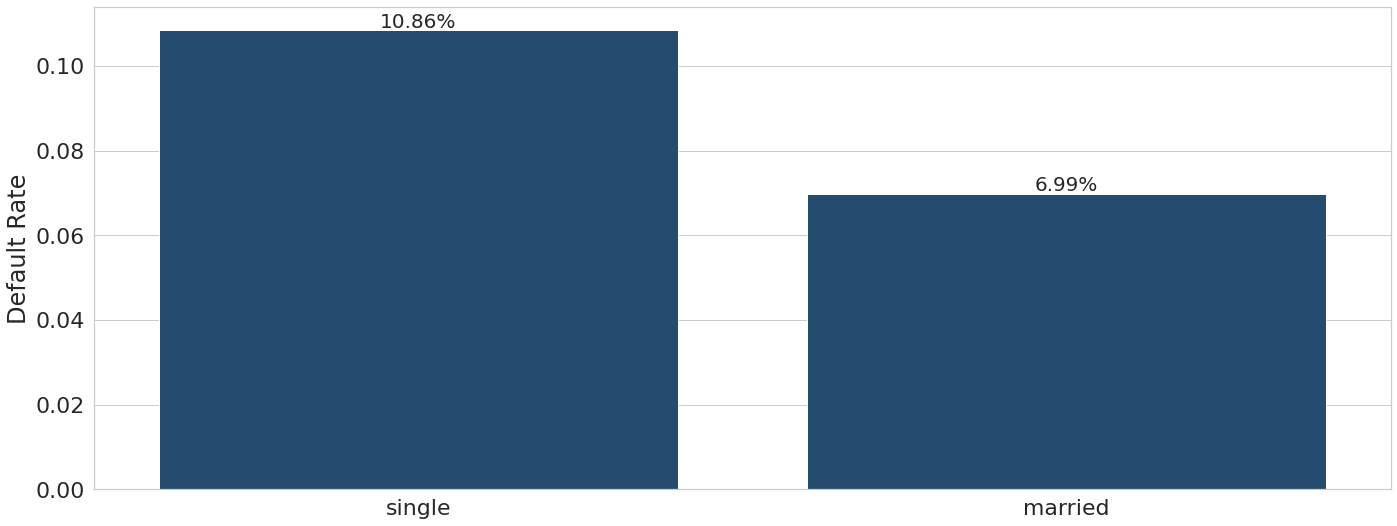

In [ ]:
rank = data=hh['Default_rate'].argsort()

sns.set(font_scale=2)
sns.set_style('whitegrid')
plots1 = sns.barplot(x='Married/Single', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots1.patches:
    plots1.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,          
                    bar.get_height()), ha='center', va='center',
                   size=20, xytext=(0, 8), 
                   textcoords='offset points')
plt.xlabel('')
plt.ylabel('Default Rate')

### Married/Single and Income

In [ ]:
df_group =  df.groupby(['Income_Flag','Married/Single',  'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['Income_Flag','Married/Single', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Income_Flag','Married/Single'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
df_group[df_group['Risk_Flag']==1]
# hh = df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)
# hh

,Income_Flag,Married/Single,Risk_Flag,Customers,total_customers,Default_rate
1,High,married,1,1675,23637,0.070863
3,High,single,1,22634,209715,0.107927
5,Low,married,1,5,413,0.012107
7,Low,single,1,347,1988,0.174547


### Married/Single and City



In [ ]:
df_group =  df.groupby(['City_Flag','Married/Single',  'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['City_Flag','Married/Single', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['City_Flag','Married/Single'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
# df_group[df_group['Risk_Flag']==1]
df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)
# hh

,City_Flag,Married/Single,Risk_Flag,Customers,total_customers,Default_rate
0,Purnia,married,1,19,26,0.730769
1,Gwalior,married,1,20,31,0.645161
2,Bhubaneswar,single,1,166,418,0.397129
3,Bettiah,single,1,120,357,0.336134
4,Sikar,single,1,188,634,0.296530
5,Gwalior,single,1,148,501,0.295409
6,Kochi,married,1,27,95,0.284211
7,Kochi,single,1,182,724,0.251381
8,Purnia,single,1,99,428,0.231308
9,Other,single,1,22078,208641,0.105818


### House_Ownership

In [ ]:
df_group =  df.groupby(['House_Ownership', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['House_Ownership', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['House_Ownership'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh = df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '10.90%')

Text(0, 8, '8.41%')

Text(0, 8, '3.72%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

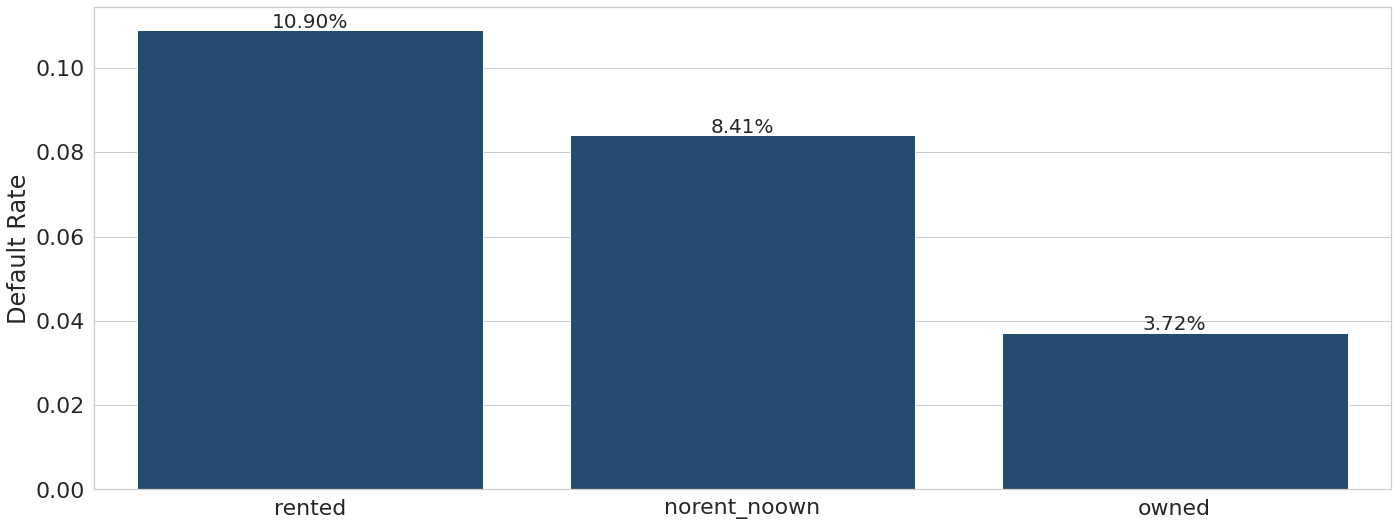

In [ ]:
rank = data=hh['Default_rate'].argsort()

sns.set(font_scale=2)
sns.set_style('whitegrid')
plots2 = sns.barplot(x='House_Ownership', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots2.patches:
    plots2.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,           
                    bar.get_height()), ha='center', va='center', 
                   size=20, xytext=(0, 8),    
                   textcoords='offset points')
    
plt.xlabel('')
plt.ylabel('Default Rate')

### Car_Ownership

In [ ]:
df_group =  df.groupby(['Car_Ownership', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
# [['House_Ownership', 'Risk_Flag','Id']]
df_group.columns=['Car_Ownership', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Car_Ownership'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh = df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '12.12%')

Text(0, 8, '6.57%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

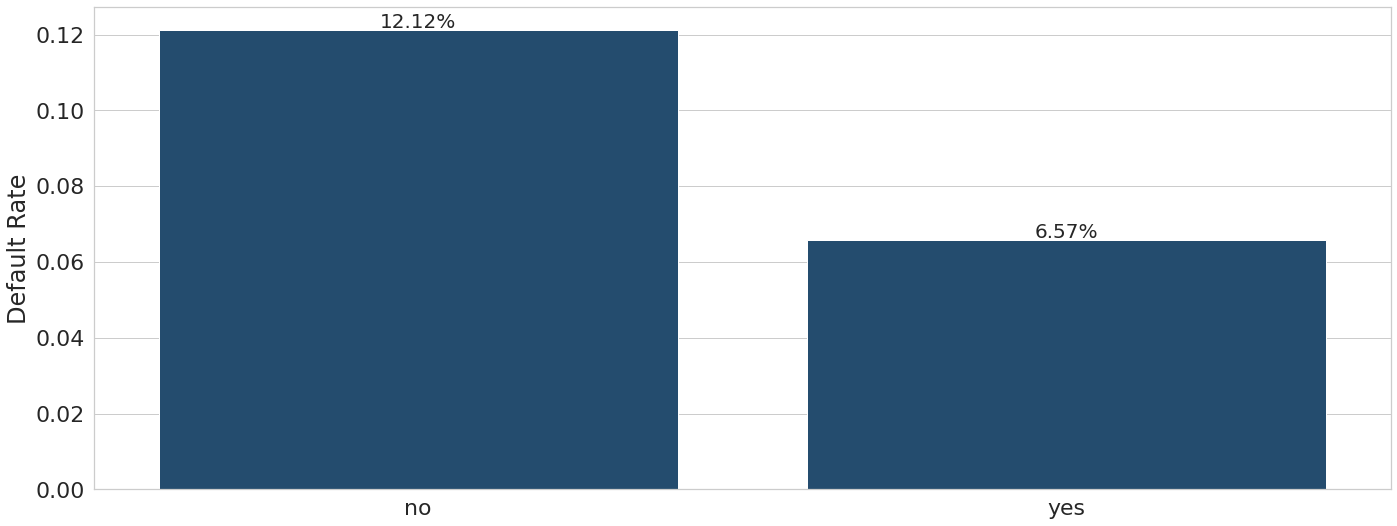

In [ ]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
plots3 = sns.barplot(x='Car_Ownership', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots3.patches:
    plots3.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,           
                    bar.get_height()), ha='center', va='center', 
                   size=20, xytext=(0, 8),    
                   textcoords='offset points')
    
plt.xlabel('')
plt.ylabel('Default Rate')

### Profession

In [ ]:
df_group =  df.groupby(['Profession', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
# [['House_Ownership', 'Risk_Flag','Id']]
df_group.columns=['Profession', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Profession'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

,Profession,Risk_Flag,Customers,total_customers,Default_rate
0,Army_officer,1,634,4311,0.147066
1,Police_officer,1,666,4626,0.143969
2,Chartered_Accountant,1,574,4152,0.138247
3,Geologist,1,565,4298,0.131456
4,Official,1,499,3798,0.131385
5,Software_Developer,1,608,4631,0.131289
6,Surveyor,1,564,4330,0.130254
7,Hotel_Manager,1,595,4810,0.123701
8,Technical_writer,1,572,4787,0.119490
9,Civil_engineer,1,511,4278,0.119448


### City

In [ ]:
df_group =  df.groupby(['CITY', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['CITY', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['CITY'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
df_group[(df_group['Risk_Flag']==1)&(df_group['Default_rate']>0.2)].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

,CITY,Risk_Flag,Customers,total_customers,Default_rate
0,Bhubaneswar,1,167,500,0.334000
1,Gwalior,1,168,532,0.315789
2,Bettiah,1,122,407,0.299754
3,Sikar,1,191,712,0.268258
4,Purnia,1,118,454,0.259912
5,Kochi,1,209,819,0.255189
6,Kottayam,1,183,743,0.246299
7,Satna,1,224,928,0.241379
8,Raiganj,1,154,653,0.235835
9,Ghaziabad,1,196,853,0.229777


### City Flag

In [ ]:
df_group =  df.groupby(['City_Flag', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
# [['House_Ownership', 'Risk_Flag','Id']]
df_group.columns=['City_Flag', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['City_Flag'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh = df_group[(df_group['Risk_Flag']==1)].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '33.40%')

Text(0, 8, '31.58%')

Text(0, 8, '29.98%')

Text(0, 8, '26.83%')

Text(0, 8, '25.99%')

Text(0, 8, '25.52%')

Text(0, 8, '10.20%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

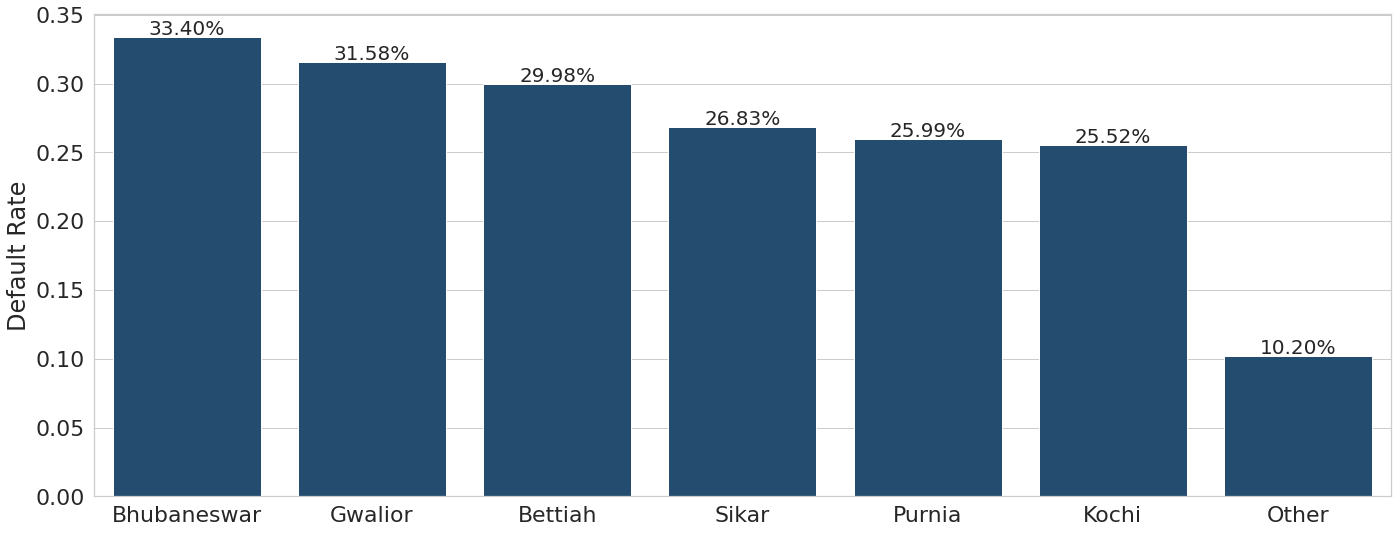

In [ ]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
plots4 = sns.barplot(x='City_Flag', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots4.patches:
    plots4.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,           
                    bar.get_height()), ha='center', va='center', 
                   size=20, xytext=(0, 8),    
                   textcoords='offset points')
    
plt.xlabel('')
plt.ylabel('Default Rate')

### State

In [ ]:
df_group =  df.groupby(['STATE', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
# [['House_Ownership', 'Risk_Flag','Id']]
df_group.columns=['STATE', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['STATE'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

,STATE,Risk_Flag,Customers,total_customers,Default_rate
0,Manipur,1,172,770,0.223377
1,Jammu_and_Kashmir,1,283,1657,0.170791
2,Kerala,1,866,5374,0.161146
3,Madhya_Pradesh,1,1940,13059,0.148557
4,Odisha,1,585,4350,0.134483
5,Rajasthan,1,1125,8544,0.131671
6,Bihar,1,2340,18606,0.125766
7,Assam,1,816,6588,0.123862
8,Jharkhand,1,1002,8394,0.119371
9,Himachal_Pradesh,1,93,782,0.118926


### State Flag

In [ ]:
df_group =  df.groupby(['STATE_Flag', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['STATE_Flag',  'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['STATE_Flag',])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh = df_group[df_group['Risk_Flag']==1].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '16.11%')

Text(0, 8, '14.86%')

Text(0, 8, '13.45%')

Text(0, 8, '13.17%')

Text(0, 8, '12.58%')

Text(0, 8, '9.58%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

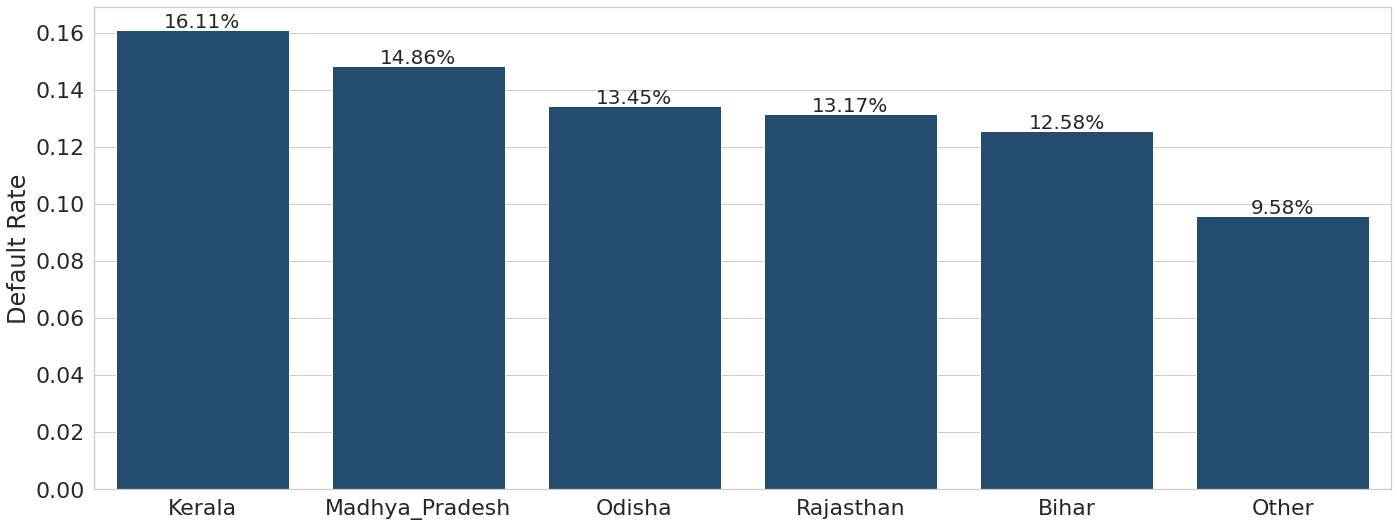

In [ ]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
plots5 = sns.barplot(x='STATE_Flag', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots5.patches:
    plots5.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,           
                    bar.get_height()), ha='center', va='center', 
                   size=20, xytext=(0, 8),    
                   textcoords='offset points')
    
plt.xlabel('')
plt.ylabel('Default Rate')

### Income Flag

In [ ]:
df_group =  df.groupby(['Income_Flag', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
# [['House_Ownership', 'Risk_Flag','Id']]
df_group.columns=['Income_Flag', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Income_Flag'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh = df_group[(df_group['Risk_Flag']==1)].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '14.66%')

Text(0, 8, '10.42%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

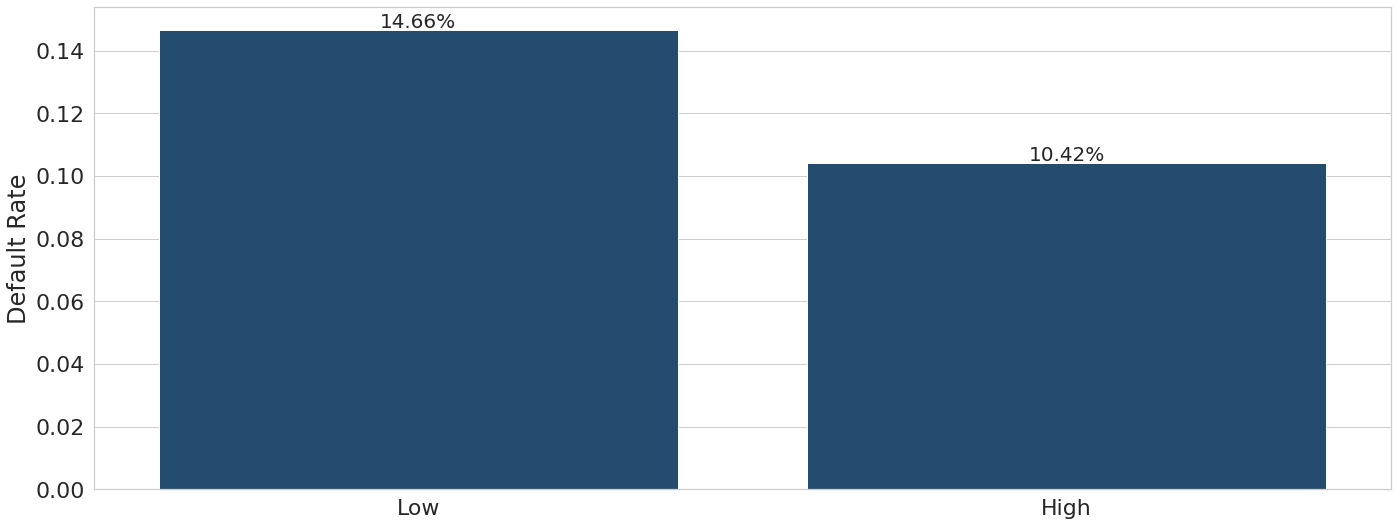

In [ ]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
plots6 = sns.barplot(x='Income_Flag', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots6.patches:
    plots6.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,           
                    bar.get_height()), ha='center', va='center', 
                   size=20, xytext=(0, 8),    
                   textcoords='offset points')
    
plt.xlabel('')
plt.ylabel('Default Rate')

### Age Flag

In [ ]:
df_group =  df.groupby(['Age_Flag', 'Risk_Flag']).agg({'Id' : pd.Series.nunique}).reset_index()
df_group.columns=['Age_Flag', 'Risk_Flag','Customers']
df_group['total_customers'] = df_group.groupby(['Age_Flag'])['Customers'].transform('sum')
df_group['Default_rate']=df_group['Customers']/df_group['total_customers']
hh =df_group[(df_group['Risk_Flag']==1)].sort_values(['Default_rate'], ascending=False).reset_index().drop('index', axis=1)

Text(0, 8, '14.90%')

Text(0, 8, '9.94%')

Text(0.5, 0, '')

Text(0, 0.5, 'Default Rate')

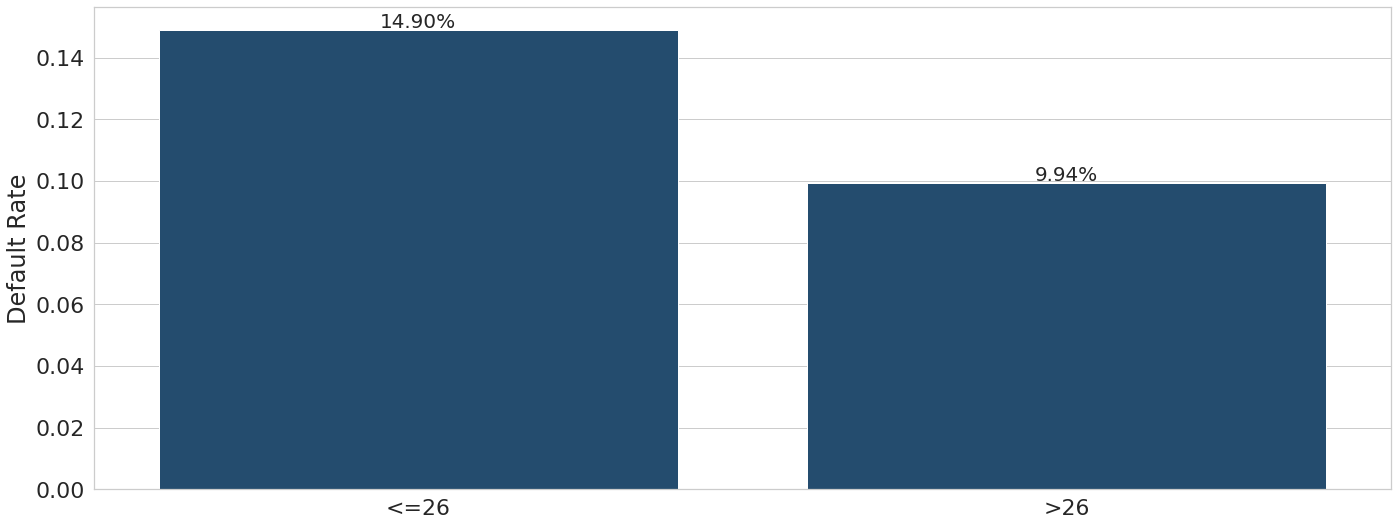

In [ ]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
plots7 = sns.barplot(x='Age_Flag', y='Default_rate', data = hh, color = '#184D7A')
for bar in plots7.patches:
    plots7.annotate(format(bar.get_height(), '.2%'),            
                   (bar.get_x() + bar.get_width() / 2,           
                    bar.get_height()), ha='center', va='center', 
                   size=20, xytext=(0, 8),    
                   textcoords='offset points')
    
plt.xlabel('')
plt.ylabel('Default Rate')

# EDA

In [ ]:
cats = df.select_dtypes(include='object').columns
nums = df.select_dtypes(exclude='object').columns[1:]
print('Kolom kategory : ', cats)
print('Kolom Number : ', nums)

Kolom kategory :  Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE', 'Income_Flag', 'Age_Flag', 'City_Flag', 'STATE_Flag'],
      dtype='object')
Kolom Number :  Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'exp_flag'],
      dtype='object')


## Univariate Analysis
Setelah melakukan analisis sederhana tentang statistik deskriptif, sekarang kita fokus pada satu-persatu kolom dengan *Univariate Analysis*

In [ ]:
nums_p1 = ['Income', 'Age', 'Experience',  'exp_flag', 'Risk_Flag']
nums_p2 = ['CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']

### Boxplot

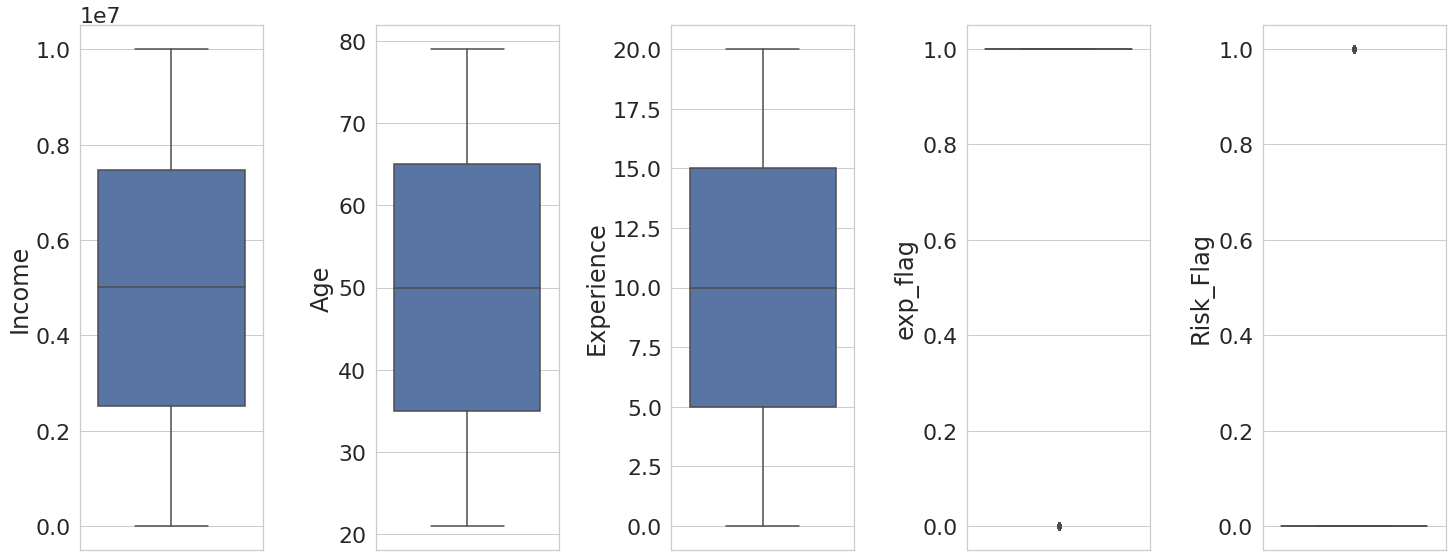

In [ ]:
box_nums = len(nums_p1)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.boxplot(y=nums_p1[i], data=df)
    plt.tight_layout()

Dari plot di atas dapat di simpulkan bahwa Income, experience dan age memiliki distribusi normal

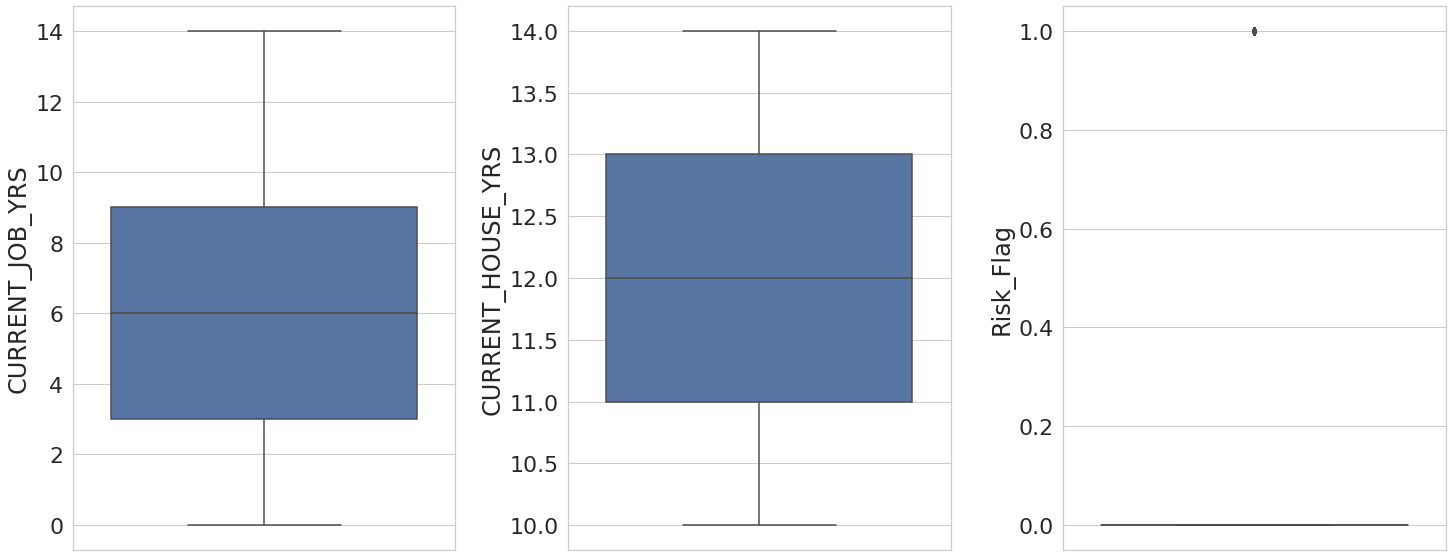

In [ ]:
box_nums = len(nums_p2)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.boxplot(y=nums_p2[i], data=df)
    plt.tight_layout()

* Data pada kolom `CURRENT_JOB_YRS` dan `CURRENT_HOUSE_YRS` tidak memiliki outlier 
* Data pada kolom `CURRENT_JOB_YRS` memiliki sedikit kecenderungan pada positive Skewed sedangkan data pada  `CURRENT_HOUSE_YRS`terlihat terdistribusi normal 

### KDE Plot

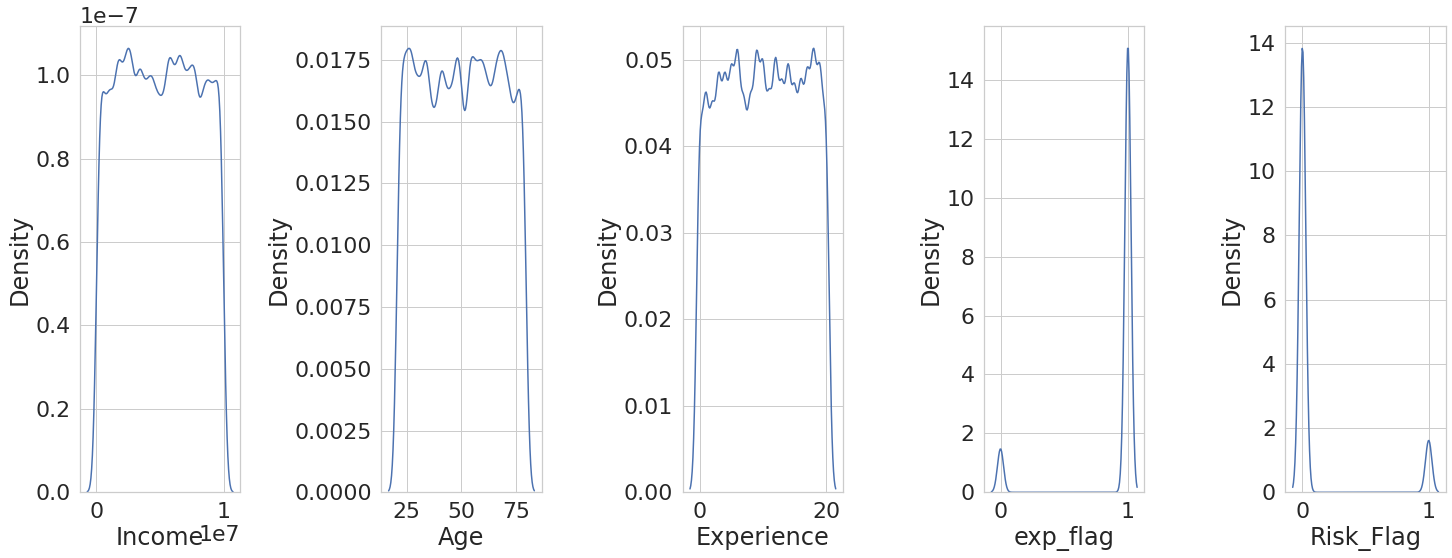

In [ ]:
box_nums = len(nums_p1)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.kdeplot(nums_p1[i],data=df)
    plt.tight_layout()

Dari plot di atas dapat di simpulkan bahwa Income, experience dan age memiliki distribusi normal

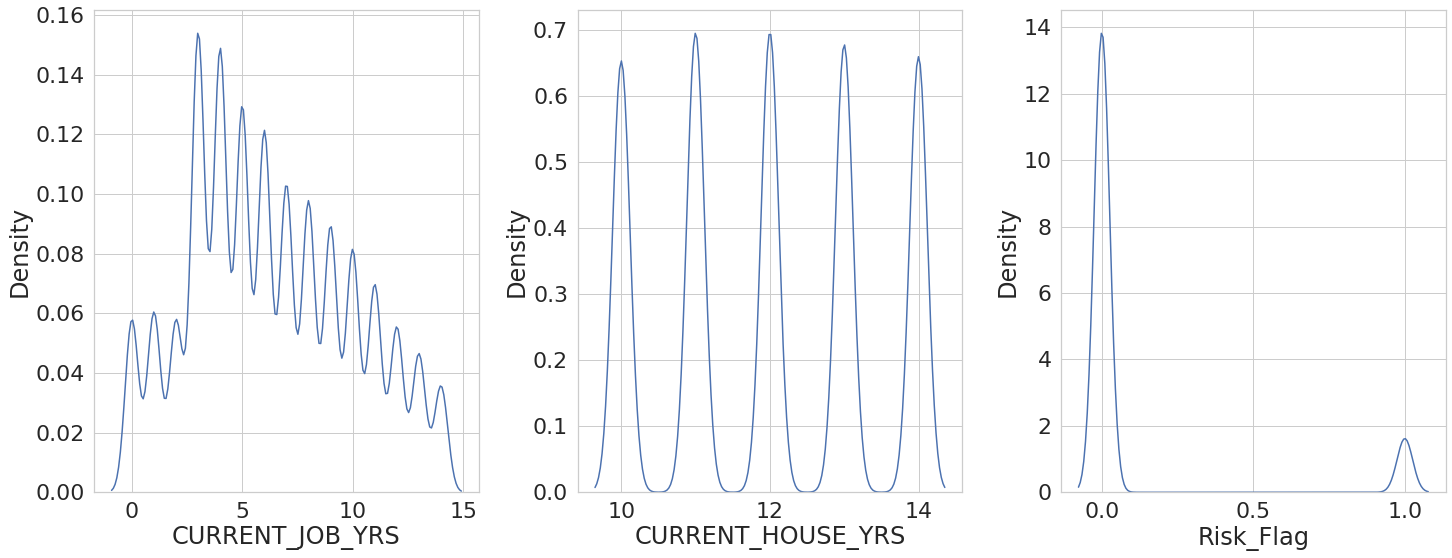

In [ ]:
box_nums = len(nums_p2)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.kdeplot(nums_p2[i],data=df)
    plt.tight_layout()

* Data pada kolom `CURRENT_JOB_YRS` terbukti lebih cenderung pada positive skewed
* Data pada kolom `CURRENT_HOUSE_YRS` terlihat terdistribusi normal dan datanya hanya terdapat 5 macam yaitu dengan nilai 10, 11, 12, 13, dan 14

### Violin Plot

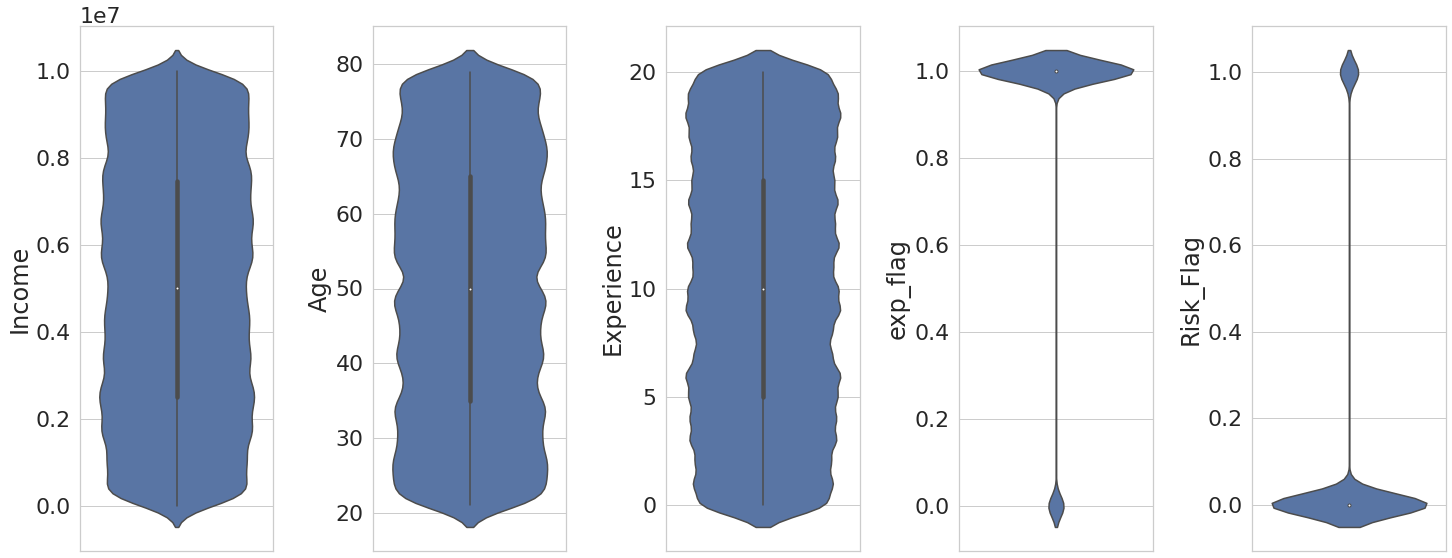

In [ ]:
box_nums = len(nums_p1)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.violinplot(y=df[nums_p1[i]],  orient='v')
    plt.tight_layout()

Dari plot di atas dapat di simpulkan bahwa Income, experience dan age memiliki distribusi normal

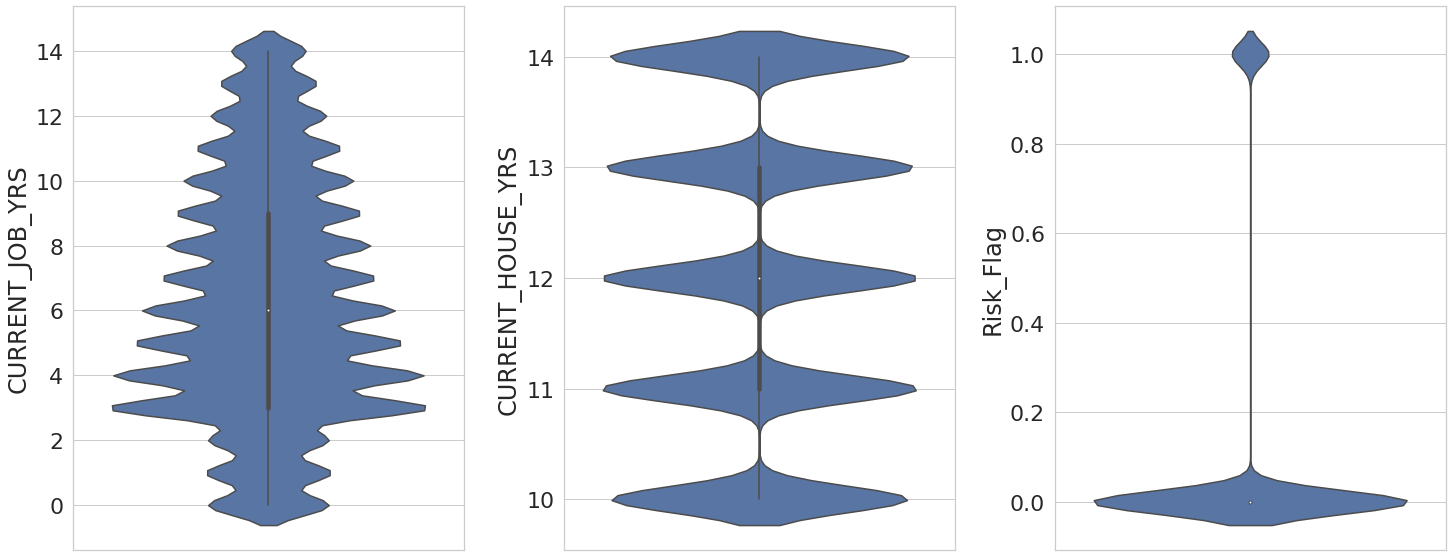

In [ ]:
box_nums = len(nums_p2)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.violinplot(y=df[nums_p2[i]],  orient='v')
    plt.tight_layout()

Terlihat pada violin plot ini memperkuat pernyataan bahwa data pada kolom `CURRENT_JOB_YRS` terbukti lebih cenderung pada positive skewed dan data pada kolom `CURRENT_HOUSE_YRS` terdistribusi normal dan datanya hanya terdapat 5 macam yaitu dengan nilai 10, 11, 12, 13, dan 14

## Bivariate Analysis
Setelah menilik setiap kolom secara individual, sekarang kita akan melihat hubungan antar kolom. Mengetahui hubungan antar kolom dapat membantu kita memilih fitur-fitur yang paling penting dan mengesampingkan *feature* yang redundan.

### *Numeric*

### Heatmap

<Figure size 864x864 with 0 Axes>

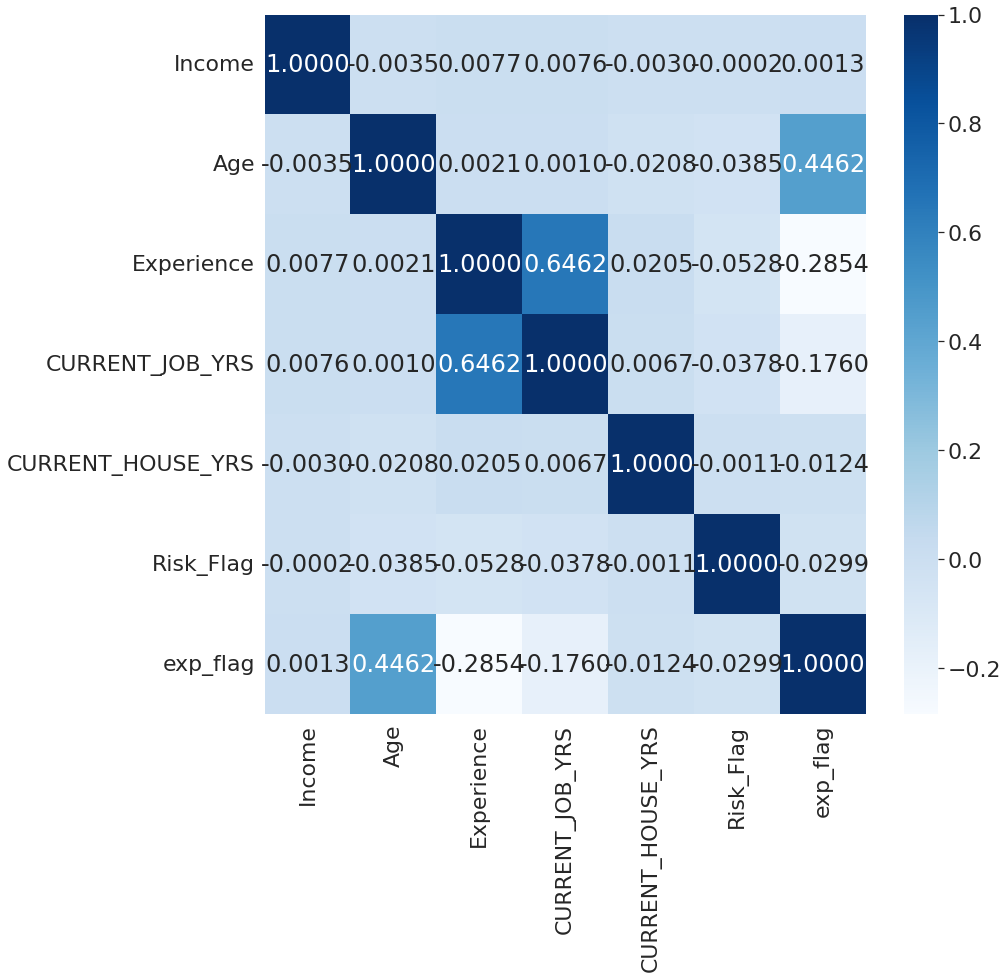

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(df[df.columns[1:]].corr(), cmap='Blues', annot=True, fmt='.4f')

Korelasi tertinggi ada pada hubungan `Experience` dan `CURRENT_JOB_YEARS` dengan nilai korelasi 0.6656 . Jika dilihat dari datanya pun beberapa row pada data kolom `Experience` dan kolom `CURRENT_JOB_YEARS` sama nilainya

### Pairplot

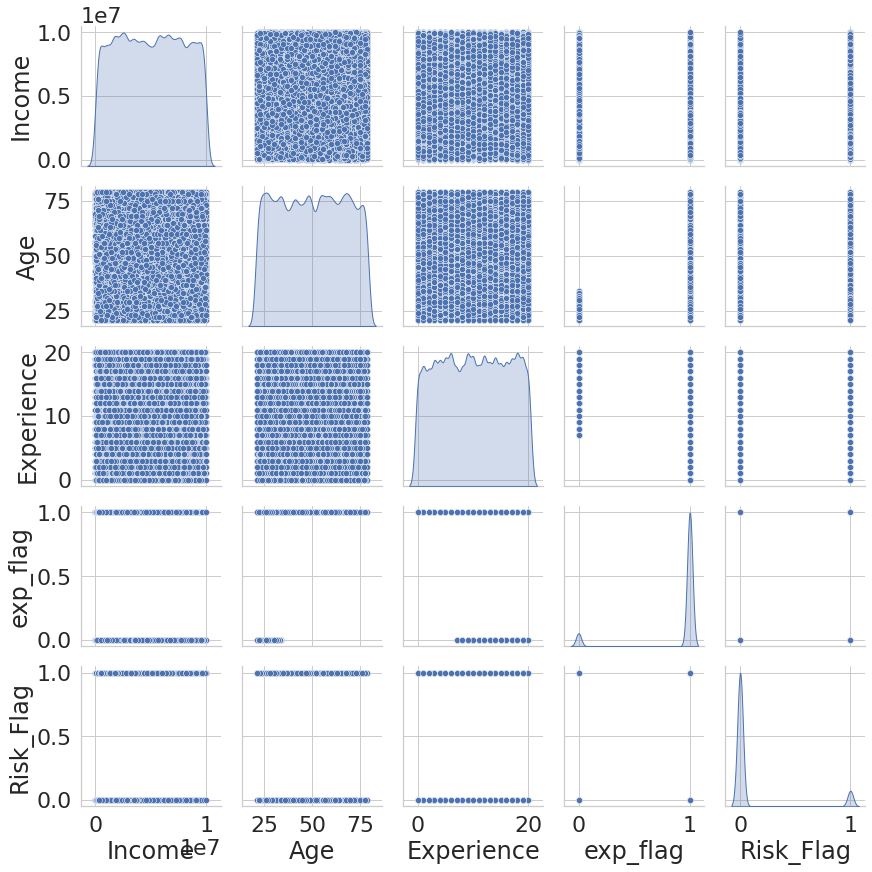

In [ ]:
sns.pairplot(df[nums_p1], diag_kind='kde')

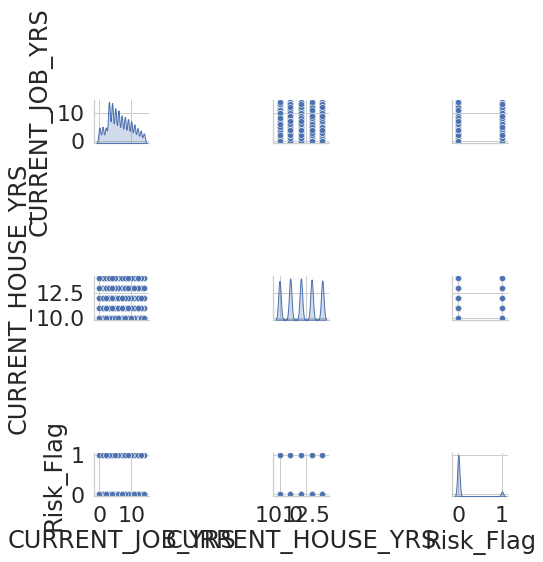

In [ ]:
sns.pairplot(df[nums_p2], diag_kind='kde')

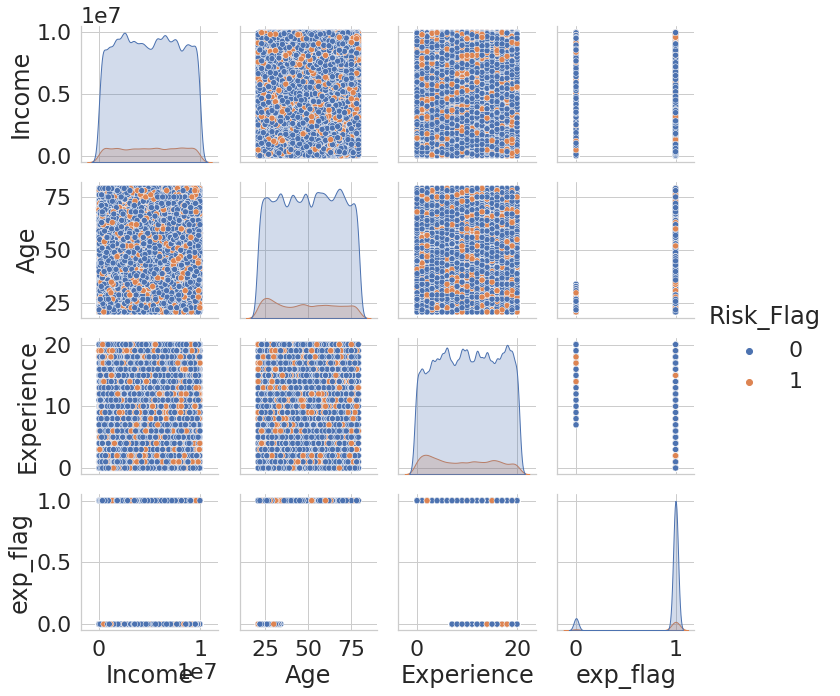

In [ ]:
sns.pairplot(df[nums_p1], diag_kind='kde', hue='Risk_Flag')

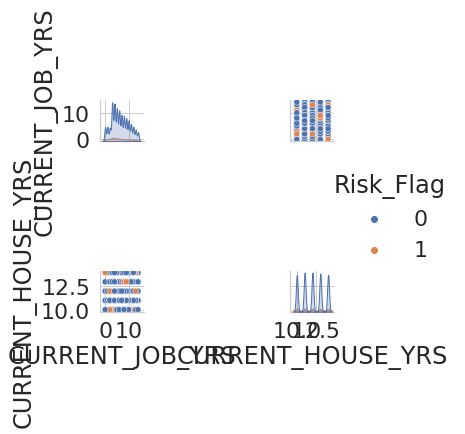

In [ ]:
sns.pairplot(df[nums_p2], diag_kind='kde', hue='Risk_Flag')

### Box plots

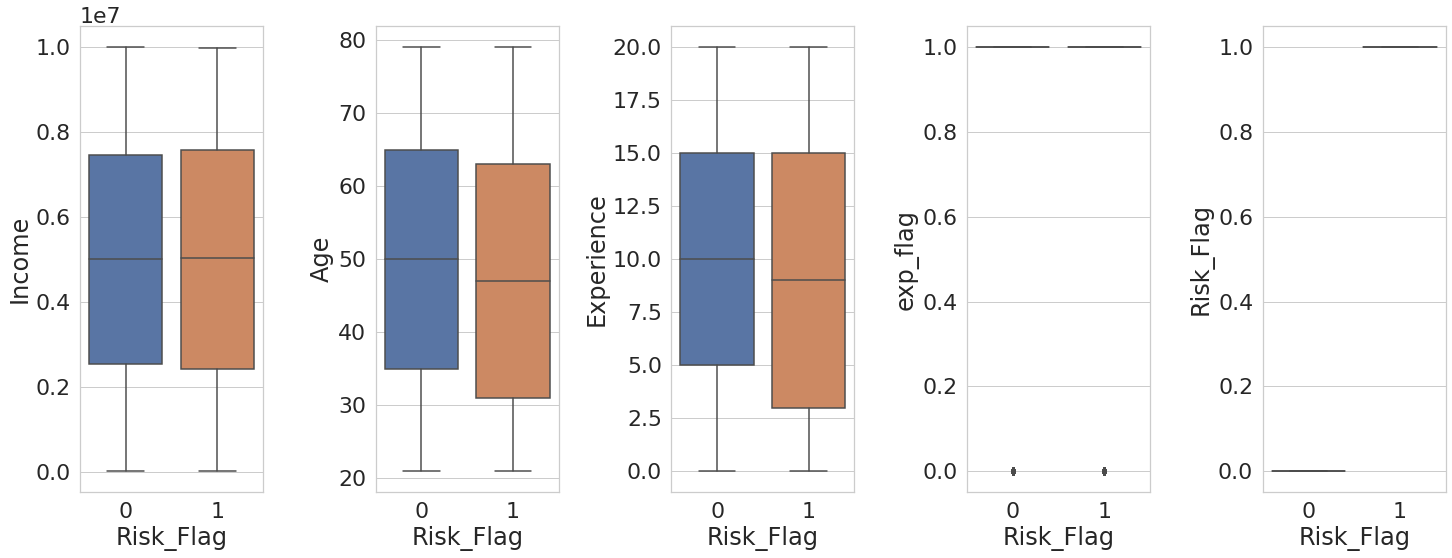

In [ ]:
box_nums = len(nums_p1)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.boxplot(y=nums_p1[i], x='Risk_Flag', data=df)
    plt.tight_layout()

Dari Boxplot di atas dapat disimpulkan bahwa income yang rendah cenderung defaulter dan age yang muda cenderung defaulter, experience yang sedikit cenderung defaulter, current job year yang sedikit cenderung defaulter, current house cenderung tidak ada perbedaan antara yang defaulter maupun yang non defaulter

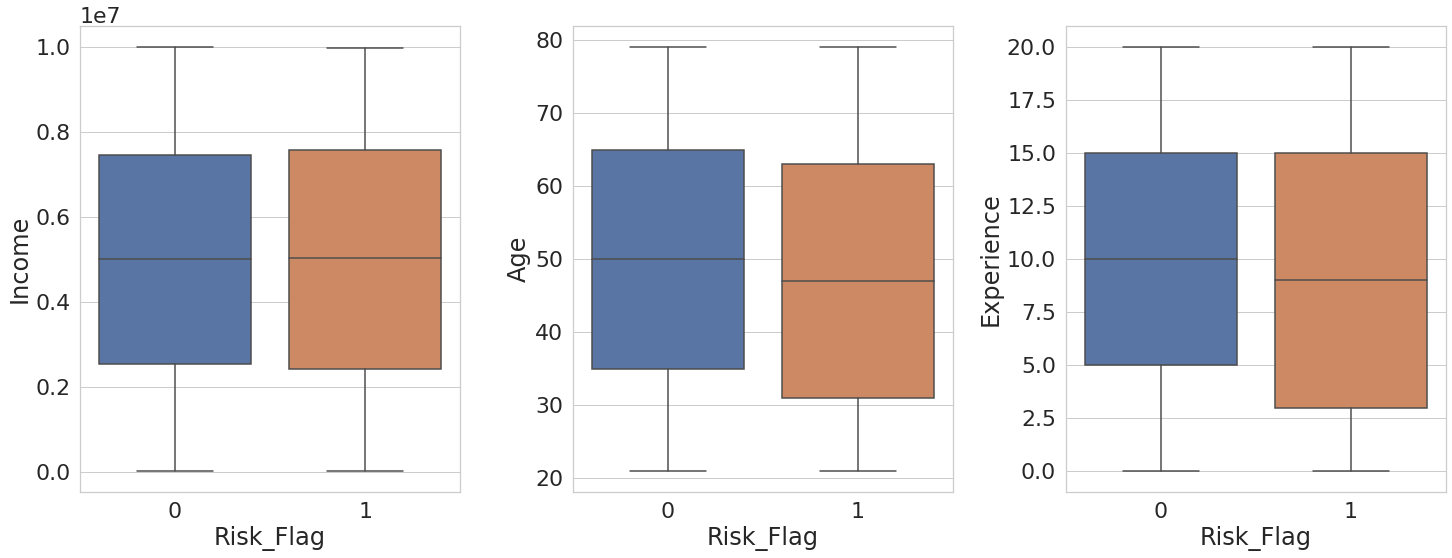

In [ ]:
box_nums = len(nums_p2)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.boxplot(y=nums_p1[i], x='Risk_Flag', data=df)
    plt.tight_layout()

### KDE plots

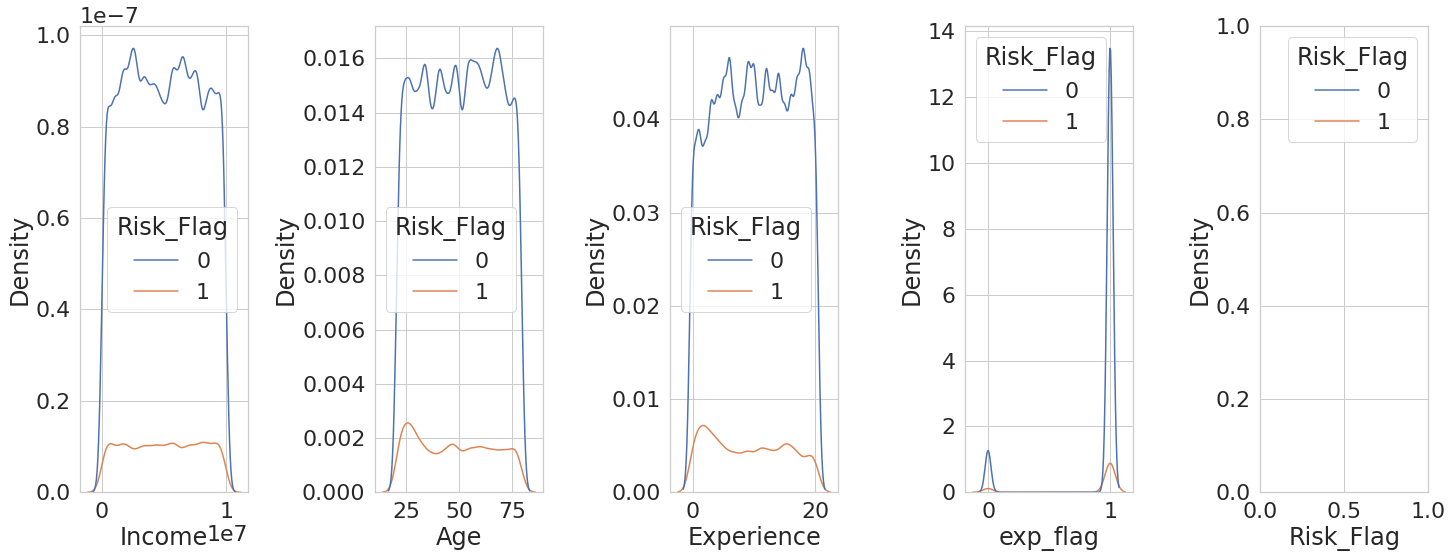

In [ ]:
box_nums = len(nums_p1)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.kdeplot(nums_p1[i], hue='Risk_Flag', data=df)
    plt.tight_layout()

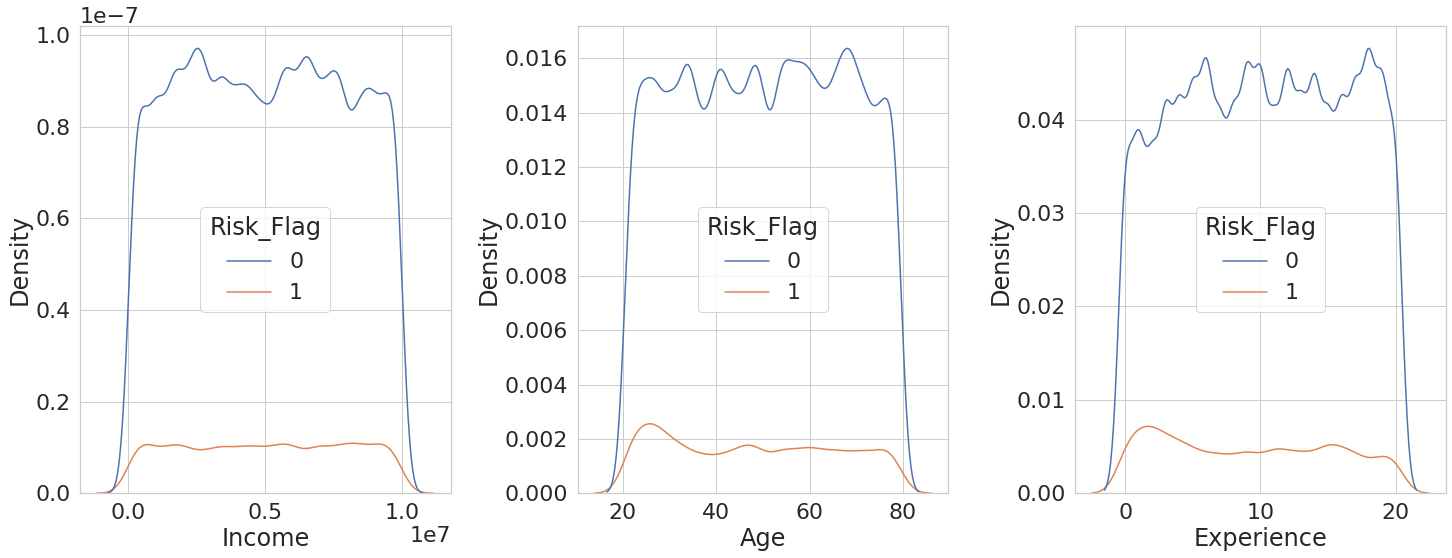

In [ ]:
box_nums = len(nums_p2)
for i in range(0, box_nums):
    plt.subplot(1, box_nums, i+1)
    sns.kdeplot(nums_p1[i], hue='Risk_Flag', data=df)
    plt.tight_layout()

### *Categorical*

In [ ]:
dfcopy1 = df.copy()
dfcat = dfcopy1.select_dtypes(include = 'object').copy()
dfcat['Risk_Flag'] = dfcopy1.loc[dfcat.index, 'Risk_Flag'].copy()
dfcat.head()

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Income_Flag,Age_Flag,City_Flag,STATE_Flag,Risk_Flag
0,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,High,<=26,Other,Madhya_Pradesh,0
1,single,rented,no,Software_Developer,Parbhani,Maharashtra,High,>26,Other,Other,0
2,married,rented,no,Technical_writer,Alappuzha,Kerala,High,>26,Other,Kerala,0
3,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,High,>26,Bhubaneswar,Odisha,1
4,single,rented,no,Civil_servant,Tiruchirappalli,Tamil_Nadu,High,>26,Other,Other,1


### Count Plot

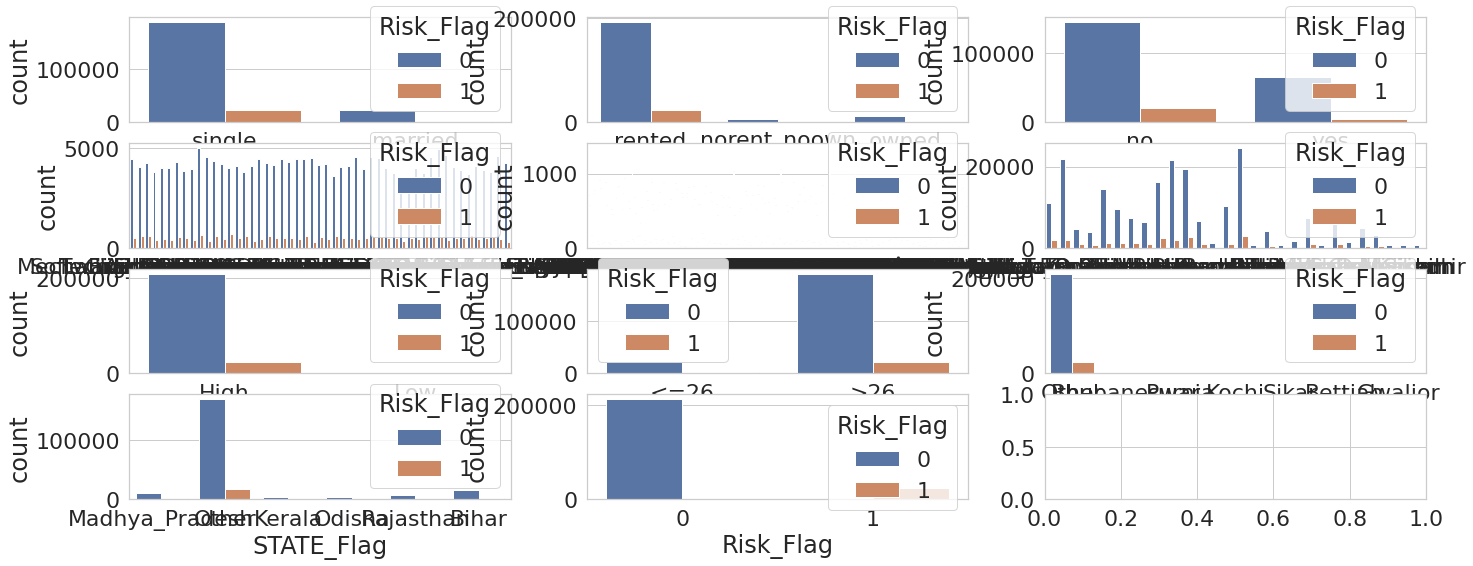

In [ ]:
fig, axes = plt.subplots(4,3 )
for cat, ax in zip(dfcat, axes.flatten()):
    sns.countplot(cat, data=dfcat, hue='Risk_Flag', ax=ax)

### Chi-Squared Test

In [ ]:
from scipy.stats import chi2_contingency
chi1 = pd.crosstab(index=dfcat['CITY'], columns=dfcat['STATE'])
cc1 = chi2_contingency(chi1)
print(cc1[1])

0.0


# Machine Learning Models

In [ ]:
nums = df.select_dtypes(exclude='object').columns[1:]
cats = df.select_dtypes(include='object').columns

In [ ]:
df_copy = df.copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
df_copy['CURRENT_JOB_YRS_norm'] = MinMaxScaler().fit_transform(df_copy['CURRENT_JOB_YRS'].values.reshape(len(df_copy), 1))
df_copy['CURRENT_HOUSE_YRS_norm'] = MinMaxScaler().fit_transform(df_copy['CURRENT_HOUSE_YRS'].values.reshape(len(df_copy), 1))
df_copy['Experience_norm'] = MinMaxScaler().fit_transform(df_copy['Experience'].values.reshape(len(df_copy), 1))
df_copy['Age_std'] = StandardScaler().fit_transform(df_copy['Age'].values.reshape(len(df_copy), 1))
df_copy['Income_std'] = StandardScaler().fit_transform(df_copy['Income'].values.reshape(len(df_copy), 1))

In [ ]:
df_copy.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Income_Flag,Age_Flag,exp_flag,City_Flag,STATE_Flag,CURRENT_JOB_YRS_norm,CURRENT_HOUSE_YRS_norm,Experience_norm,Age_std,Income_std
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,High,<=26,1,Other,Madhya_Pradesh,0.214286,0.75,0.15,-1.572402,-1.287029
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,High,>26,1,Other,Other,0.642857,0.75,0.50,-0.578079,0.894884
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,High,>26,1,Other,Kerala,0.285714,0.00,0.20,0.942650,-0.351733
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,High,>26,1,Bhubaneswar,Odisha,0.142857,0.50,0.10,-0.519590,0.436258
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli,Tamil_Nadu,3,14,1,High,>26,1,Other,Other,0.214286,1.00,0.55,-0.168652,0.266602


In [ ]:
nums_two = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

In [ ]:
df_new = df_copy.drop(columns=nums_two).copy()

In [ ]:
df_new.describe()

,Id,Risk_Flag,exp_flag,CURRENT_JOB_YRS_norm,CURRENT_HOUSE_YRS_norm,Experience_norm,Age_std,Income_std
count,235753.000000,235753.000000,235753.000000,235753.000000,235753.000000,235753.000000,2.357530e+05,2.357530e+05
mean,126778.079872,0.104605,0.911314,0.451136,0.499652,0.503988,1.128594e-16,-5.698303e-17
std,73477.449549,0.306045,0.284291,0.260531,0.349842,0.300849,1.000002e+00,1.000002e+00
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.689381e+00,-1.737116e+00
25%,62947.000000,0.000000,1.000000,0.214286,0.250000,0.250000,-8.705272e-01,-8.646983e-01
50%,126824.000000,0.000000,1.000000,0.428571,0.500000,0.500000,6.816461e-03,1.039021e-03
75%,191067.000000,0.000000,1.000000,0.642857,0.750000,0.750000,8.841601e-01,8.604126e-01
max,252000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.703014e+00,1.738821e+00


In [ ]:
for cat in ['Married/Single', 'Car_Ownership', 'Profession','Income_Flag', 'Age_Flag', 'City_Flag', 'STATE_Flag','House_Ownership']:
# for cat in cats:
    onehots = pd.get_dummies(df_new[cat], prefix=cat)
    df_new = df_new.join(onehots)

In [ ]:
drop_cats = ['Married/Single_single', 'Car_Ownership_no', 'Income_Flag_Low', 'Age_Flag_<=26']

In [ ]:
df_new = df_new.drop(columns=cats).copy()

In [ ]:
df_new = df_new.drop(columns=drop_cats).copy()
df_new = df_new.rename(columns={"Married/Single_married": "Is_Maried", "Car_Ownership_yes": "Has_car"})

In [ ]:
df_new.shape

(235753, 79)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, proba, pred_val, proba_val, y_val, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, proba, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

    print("Accuracy (Validation Set): %.2f" % accuracy_score(y_val, pred_val))
    print("Precision (Validation Set): %.2f" % precision_score(y_val, pred_val))
    print("Recall (Validation Set): %.2f" % recall_score(y_val, pred_val))
    print("F1-Score (Validation Set): %.2f" % f1_score(y_val, pred_val))
    
    fpr, tpr, thresholds = roc_curve(y_val, proba_val, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')    

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

In [ ]:
df_new['Risk_Flag'].value_counts()[1]/df_new.shape[0]

0.10460524362362303

In [ ]:
X = df_new.drop(columns=['Risk_Flag', 'Id'])
# X = df_new[column]
y = df_new['Risk_Flag']

In [ ]:
X.shape

(235753, 77)

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [ ]:
from imblearn import under_sampling, over_sampling
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(0.5).fit_resample(X_train, y_train)

In [ ]:
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

SMOTE
0    189959
1     94979
dtype: int64


In [ ]:
df_tes = pd.DataFrame(X_over_SMOTE)
df_tes.columns=X.columns 
df_tes.shape

(284938, 77)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tes, y_over_SMOTE, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.linear_model import LogisticRegression
lReg = LogisticRegression(random_state=42)
lReg.fit(X_train, y_train)

y_pred = lReg.predict(X_test)
y_proba = lReg.predict_proba(X_test)
y_proba = y_proba[:,1]
# eval_classification(lReg, y_pred, y_proba, X_train, y_train, X_test, y_test)

y_pred_val = lReg.predict(X_val)
y_proba_val = lReg.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
eval_classification(lReg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.56
Recall (Test Set): 0.14
F1-Score (Test Set): 0.22
AUC: 0.66
Accuracy (Validation Set): 0.86
Precision (Validation Set): 0.22
Recall (Validation Set): 0.14
F1-Score (Validation Set): 0.17
AUC: 0.65


In [ ]:
awal = pd.datetime.now()
print('awal', pd.datetime.now())
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_proba = y_proba[:,1]

y_pred_val = model.predict(X_val)
y_proba_val = model.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
eval_classification(model, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
print('akhir', pd.datetime.now())
print('waktu', pd.datetime.now()-awal)

awal 2021-10-15 19:22:01.353680


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Accuracy (Test Set): 0.96
Precision (Test Set): 0.94
Recall (Test Set): 0.94
F1-Score (Test Set): 0.94
AUC: 0.95
Accuracy (Validation Set): 0.95
Precision (Validation Set): 0.74
Recall (Validation Set): 0.77
F1-Score (Validation Set): 0.75
AUC: 0.87
akhir 2021-10-15 19:22:08.594008
waktu 0:00:07.240566


[Text(822.15, 524.88, 'Has_car <= 1.0\ngini = 0.445\nsamples = 227950\nvalue = [151938, 76012]\nclass = 0'),
 Text(391.5, 408.24, 'Has_car <= 0.0\ngini = 0.469\nsamples = 167559\nvalue = [104578, 62981]\nclass = 0'),
 Text(313.2, 291.6, 'House_Ownership_owned <= 0.999\ngini = 0.466\nsamples = 166031\nvalue = [104578, 61453]\nclass = 0'),
 Text(156.6, 174.95999999999998, 'City_Flag_Other <= 0.994\ngini = 0.471\nsamples = 159382\nvalue = [98755, 60627]\nclass = 0'),
 Text(78.3, 58.319999999999936, '\n  (...)  \n'),
 Text(234.89999999999998, 58.319999999999936, '\n  (...)  \n'),
 Text(469.79999999999995, 174.95999999999998, 'Profession_Computer_operator <= 0.004\ngini = 0.218\nsamples = 6649\nvalue = [5823, 826]\nclass = 0'),
 Text(391.5, 58.319999999999936, '\n  (...)  \n'),
 Text(548.1, 58.319999999999936, '\n  (...)  \n'),
 Text(469.79999999999995, 291.6, 'gini = 0.0\nsamples = 1528\nvalue = [0, 1528]\nclass = 1'),
 Text(1252.8, 408.24, 'Experience_norm <= 0.25\ngini = 0.338\nsamples =

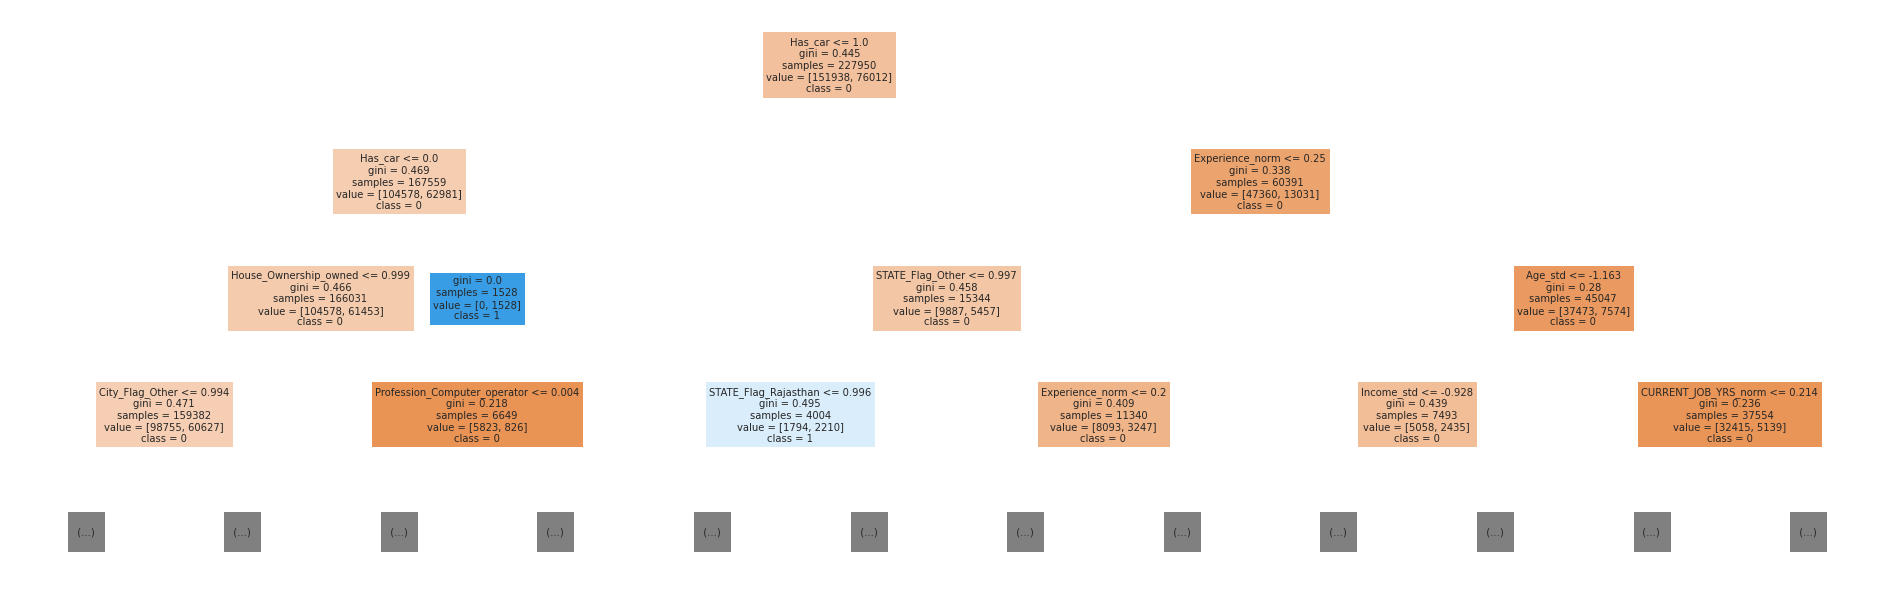

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30, 10))
tree.plot_tree(model,
               feature_names = X_train.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=3, fontsize=10)
plt.show()

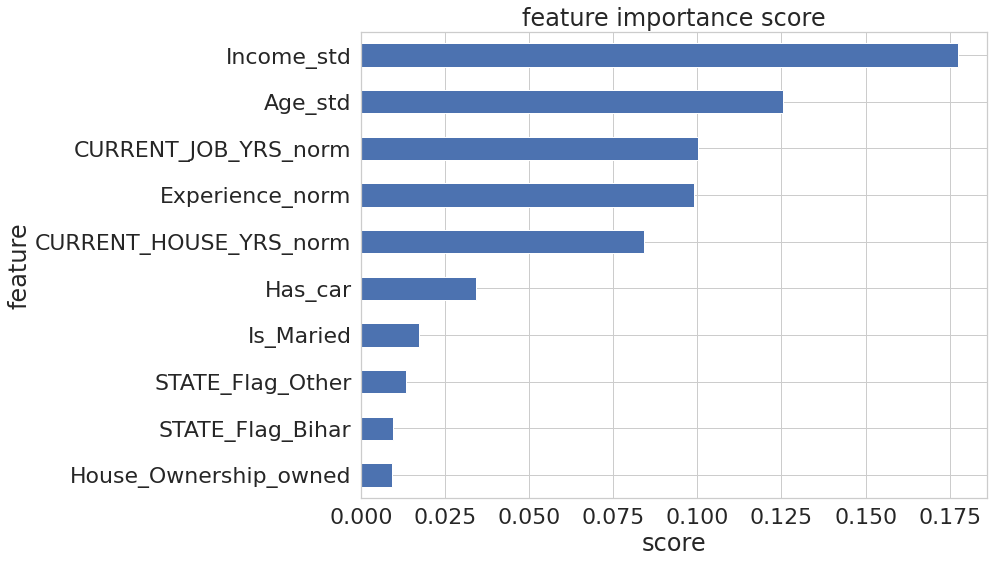

In [ ]:
show_feature_importance(model)

In [ ]:
awal = pd.datetime.now()
print('awal', awal)
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 3, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(
    # max_depth=max_depth, 
                      #  min_samples_split=min_samples_split 
                      #  min_samples_leaf=min_samples_leaf
                       max_features=max_features
                      )

# Inisialisasi Model
model = DecisionTreeClassifier(random_state=42, min_samples_split = 2, min_samples_leaf=1, max_depth=55, max_features = 'auto', criterion="gini", ccp_alpha=0.0000033)
# model = GridSearchCV(dt, hyperparameters, cv=5, scoring='precision')
model.fit(X_train, y_train)



# Predict & Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_proba = y_proba[:,1]

y_pred_val = model.predict(X_val)
y_proba_val = model.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
print('akhir', pd.datetime.now())
print('waktu', pd.datetime.now()-awal)
eval_classification(lReg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)

awal 2021-10-15 19:22:10.012339


DecisionTreeClassifier(ccp_alpha=3.3e-06, class_weight=None, criterion='gini',
                       max_depth=55, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

akhir 2021-10-15 19:22:11.242051
waktu 0:00:01.229965
Accuracy (Test Set): 0.95
Precision (Test Set): 0.94
Recall (Test Set): 0.92
F1-Score (Test Set): 0.93
AUC: 0.95
Accuracy (Validation Set): 0.95
Precision (Validation Set): 0.76
Recall (Validation Set): 0.76
F1-Score (Validation Set): 0.76
AUC: 0.88


In [ ]:
# awal = pd.datetime.now()
# print('awal', awal)
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import xgboost as xgb
# max_delta_step  = [int(x) for x in np.linspace(1, 10, num = 1)] # Maximum number of levels in tree
# min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
# max_features = ['auto', 'sqrt'] # Number of features to consider at every split
# eta = 0.01
# min_child_weight =  [1,2,3,4]

# hyperparameters = dict(min_child_weight =min_child_weight, 
#                       #  min_samples_split=min_samples_split, 
#                       #  min_samples_leaf=min_samples_leaf,
#                       #  max_features=max_features
# )
# # Init
# xg_reg= xgb.XGBClassifier(learning_rate = 0.2,objective ='binary:logistic',booster='gbtree',max_depth = 15, max_delta_step = 1,seed=42)
# xg_reg_tuned = GridSearchCV(xg_reg, hyperparameters, cv=5, scoring='recall')
# # rf = RandomForestClassifier(random_state=42)
# # rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
# xg_reg_tuned.fit(X_train,y_train)

# # Predict & Evaluation
# y_pred = xg_reg_tuned.predict(X_test)#Check performa dari model
# y_proba = xg_reg_tuned.predict_proba(X_test)
# y_proba = y_proba[:,1]


# y_pred_val = xg_reg_tuned.predict(X_val)
# y_proba_val = xg_reg_tuned.predict_proba(X_val)
# y_proba_val = y_proba_val[:,1]
# eval_classification(lReg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
# print('akhir', pd.datetime.now())
# print('waktu', pd.datetime.now()-awal)

In [ ]:
# awal = pd.datetime.now()
# print('awal', awal)
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# subsample  = [x for x in np.linspace(0, 1, num = 5)] # Maximum number of levels in tree
# # min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
# # min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
# # max_features = ['auto', 'sqrt'] # Number of features to consider at every split
# # eta = 0.01
# # min_child_weight =  [1,2,3,4]

# hyperparameters = dict(subsample =subsample, 
#                       #  min_samples_split=min_samples_split, 
#                       #  min_samples_leaf=min_samples_leaf,
#                       #  max_features=max_features
# )
# # Init
# xg_reg= xgb.XGBClassifier(objective ='binary:logistic',booster='gbtree',max_depth = 15, max_delta_step = 1,seed=42)
# xg_reg_tuned = GridSearchCV(xg_reg, hyperparameters, cv=5, scoring='recall')
# # rf = RandomForestClassifier(random_state=42)
# # rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
# xg_reg_tuned.fit(X_train,y_train)

# # Predict & Evaluation
# y_pred = xg_reg_tuned.predict(X_test)#Check performa dari model
# y_proba = xg_reg_tuned.predict_proba(X_test)
# y_proba = y_proba[:,1]


# y_pred_val = xg_reg_tuned.predict(X_val)
# y_proba_val = xg_reg_tuned.predict_proba(X_val)
# y_proba_val = y_proba_val[:,1]
# eval_classification(lReg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
# print('akhir', pd.datetime.now())
# print('waktu', pd.datetime.now()-awal)

In [ ]:
awal = pd.datetime.now()
print('awal', pd.datetime.now())
import xgboost as xgb
xg_reg = xgb.XGBClassifier(objective ='binary:logistic',booster='gbtree', eta = 0.01 ,max_delta_step = 1,max_depth = 15, min_child_weight=1, n_estimators= 100,seed=42,subsample=1)
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)
y_proba = xg_reg.predict_proba(X_test)
y_proba = y_proba[:,1]


y_pred_val = xg_reg.predict(X_val)
y_proba_val = xg_reg.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
eval_classification(xg_reg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
print('akhir', pd.datetime.now())
print('waktu', pd.datetime.now()-awal)

awal 2021-10-15 19:22:11.420668


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

Accuracy (Test Set): 0.97
Precision (Test Set): 0.99
Recall (Test Set): 0.93
F1-Score (Test Set): 0.96
AUC: 0.99
Accuracy (Validation Set): 0.96
Precision (Validation Set): 0.94
Recall (Validation Set): 0.70
F1-Score (Validation Set): 0.81
AUC: 0.92
akhir 2021-10-15 19:25:49.933829
waktu 0:03:38.513365


In [ ]:
awal = pd.datetime.now()
print('awal', pd.datetime.now())
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)
y_proba = y_proba[:,1]


y_pred_val = rf.predict(X_val)
y_proba_val = rf.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
eval_classification(lReg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
print('akhir', pd.datetime.now())
print('waktu', pd.datetime.now()-awal)

awal 2021-10-15 19:25:49.952251


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy (Test Set): 0.98
Precision (Test Set): 0.99
Recall (Test Set): 0.94
F1-Score (Test Set): 0.97
AUC: 1.00
Accuracy (Validation Set): 0.97
Precision (Validation Set): 0.96
Recall (Validation Set): 0.70
F1-Score (Validation Set): 0.81
AUC: 0.98
akhir 2021-10-15 19:27:01.264991
waktu 0:01:11.312963


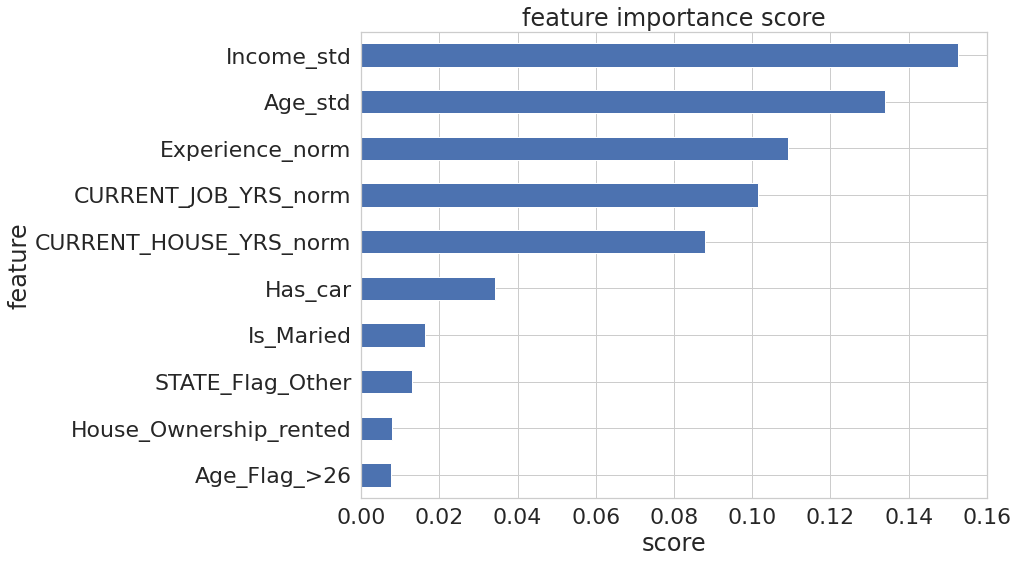

In [ ]:
show_feature_importance(rf)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
awal = pd.datetime.now()
print('awal', pd.datetime.now())

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                      #  criterion = criterion,
                       min_samples_split = [1,2,4,6,10] # Jumlah feature yg dipertimbangkan pada masing-masing split
                      )
# model = DecisionTreeClassifier(random_state=42, min_samples_split = 2, min_samples_leaf=1, max_depth=55, max_features = 'auto', criterion="gini", ccp_alpha=0.0000033)

# Init
rf_tuned = RandomForestClassifier(random_state=42, criterion='gini', max_features='auto',min_samples_split = 2, min_samples_leaf=1, max_depth=80, bootstrap=True)
# rf_tuned = RandomizedSearchCV(rf2, hyperparameters, cv=5, scoring='recall',random_state=42)
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = rf_tuned.predict(X_test)#Check performa dari model
y_proba = rf_tuned.predict_proba(X_test)
y_proba = y_proba[:,1]


y_pred_val = rf_tuned.predict(X_val)
y_proba_val = rf_tuned.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
eval_classification(lReg, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
print('akhir', pd.datetime.now())
print('waktu', pd.datetime.now()-awal)

awal 2021-10-15 19:27:01.809504


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy (Test Set): 0.98
Precision (Test Set): 0.99
Recall (Test Set): 0.94
F1-Score (Test Set): 0.97
AUC: 1.00
Accuracy (Validation Set): 0.97
Precision (Validation Set): 0.96
Recall (Validation Set): 0.70
F1-Score (Validation Set): 0.81
AUC: 0.98
akhir 2021-10-15 19:28:18.516868
waktu 0:01:16.707582


In [ ]:
preddrf_tune = pd.DataFrame(y_pred_val)

In [ ]:
y_val.value_counts()
# [1]/len(preddrf_tune)

0    21133
1     2443
Name: Risk_Flag, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix  = confusion_matrix(y_val, y_pred_val)
confusion_matrix(y_val, y_pred_val)

array([[21062,    71],
       [  724,  1719]])

In [ ]:
719/(719+21046)

0.0330346887204227

In [ ]:
719+21046

21765

In [ ]:
87+1724

1811

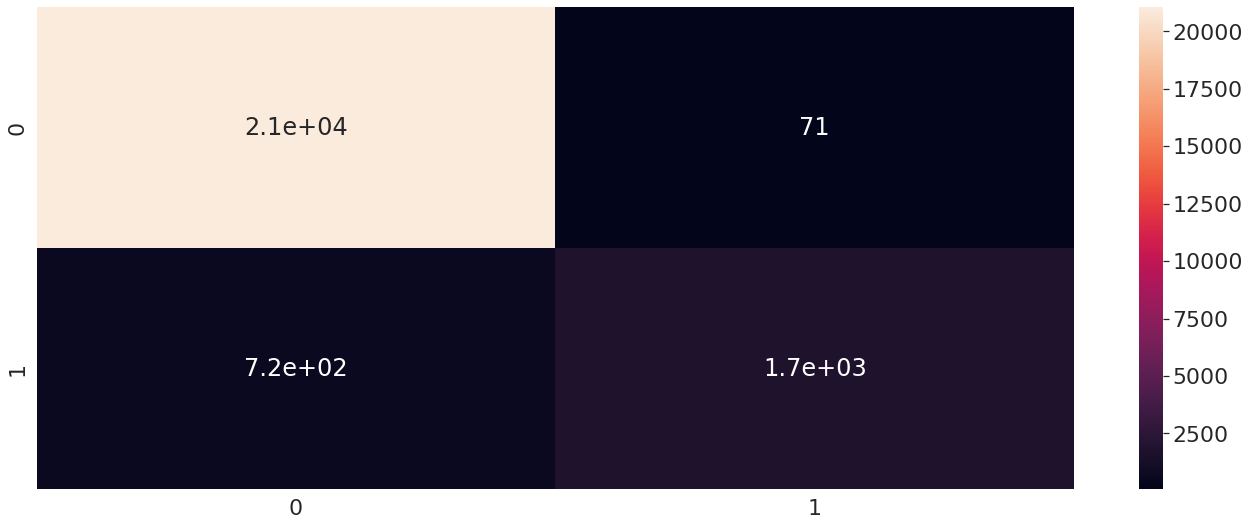

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

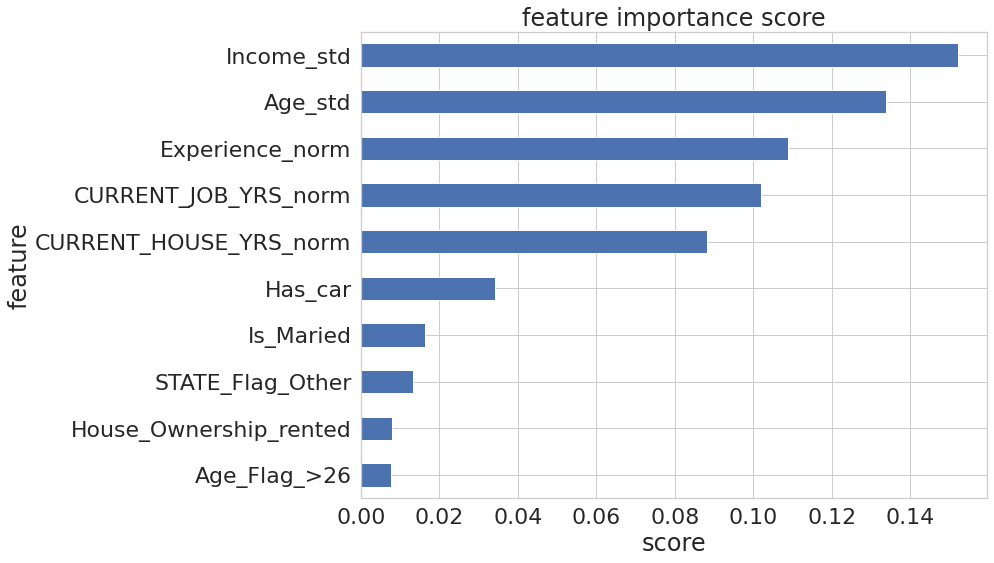

In [ ]:
show_feature_importance(rf_tuned)

In [ ]:
awal = pd.datetime.now()
print('awal', pd.datetime.now())
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42, min_samples_split = 2, min_samples_leaf=1, max_depth=55, max_features = 'auto', criterion="gini"), n_estimators=200, learning_rate=0.0025)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

# model = RandomizedSearchCV(abc, parameters,verbose=3,scoring='recall',n_jobs=-1,random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_proba = y_proba[:,1]

y_pred_val = model.predict(X_val)
y_proba_val = model.predict_proba(X_val)
y_proba_val = y_proba_val[:,1]
eval_classification(model, y_pred, y_proba, y_pred_val, y_proba_val, y_val, y_test)
print('akhir', pd.datetime.now())
print('waktu', pd.datetime.now()-awal)

awal 2021-10-15 19:28:19.540959


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=55,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

Accuracy (Test Set): 0.98
Precision (Test Set): 0.99
Recall (Test Set): 0.95
F1-Score (Test Set): 0.97
AUC: 1.00
Accuracy (Validation Set): 0.97
Precision (Validation Set): 0.95
Recall (Validation Set): 0.71
F1-Score (Validation Set): 0.81
AUC: 0.98
akhir 2021-10-15 19:32:12.615644
waktu 0:03:53.074889
